In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel("C:/Users/nehue/Documents/programas_de_python/machine_learning/my_projects/customer_segmentation/data/raw/Online Retail.xlsx")

# Data Preprocessing

In [3]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df = df.drop(["Description"],axis=1)

In [6]:
df = df.dropna()

In [7]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

<AxesSubplot:>

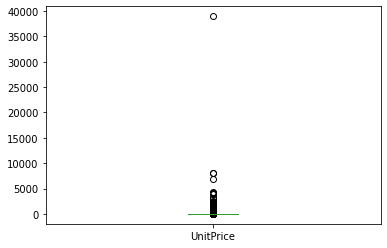

In [8]:
df["UnitPrice"].plot(kind="box")

In [9]:
df_sorted = df[df["Quantity"]!=-1].sort_values(by=["UnitPrice"], ascending=False)

In [10]:
len(df_sorted[df_sorted["UnitPrice"]>1000])

22

In [11]:
df = df_sorted[df_sorted["UnitPrice"]<1000][df_sorted["Quantity"]>0][df["UnitPrice"]>0]

C:\Users\nehue\AppData\Local\Temp\ipykernel_6764\41533685.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df_sorted[df_sorted["UnitPrice"]<1000][df_sorted["Quantity"]>0][df["UnitPrice"]>0]


In [12]:
import re

In [13]:
stc = df["StockCode"].unique()

stock_with_words = [stockcode for stockcode in stc if type(stockcode)!=int]
stock_with_words = [sc for sc in stock_with_words if not any(char.isdigit() for char in sc)]

In [14]:
stock_with_words

['DOT', 'M', 'POST', 'BANK CHARGES', 'PADS']

In [15]:
for word in stock_with_words:

    df = df[df["StockCode"]!=word]

<AxesSubplot:>

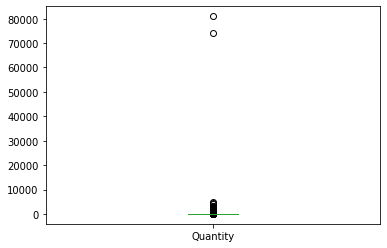

In [16]:
df["Quantity"].plot(kind="box")

In [17]:
df[df["Quantity"]>10000]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
61619,541431,23166,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom


In [18]:
df = df[df["Quantity"]<3000]


# Feature selection and engineering

- Create more features (based on each customer): average_purchase_quantity, average_purchase_expense, Purchase_frequency, time_as_buyer, lifetime_expenses, unique_items_bought

- Encode categorical features: Country



In [19]:
# average_purchase_quantity

df['average_purchase_quantity'] = df.groupby('CustomerID')['UnitPrice'].transform('mean')

In [20]:
# average_purchase_expense

df['average_purchase_expense'] = df.groupby('CustomerID')['Quantity'].transform('mean')

In [21]:
# Purchase_frequency

purchase_dates = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max', "count"])

purchase_dates['Purchase_frequency'] = (purchase_dates['max'] - purchase_dates['min']).dt.days / purchase_dates["count"]

df = pd.merge(df, purchase_dates['Purchase_frequency'], on='CustomerID')

In [22]:
# time_as_buyer

purchase_dates = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])

purchase_dates['time_as_buyer'] = (purchase_dates['max'] - purchase_dates['min']).dt.days

df = pd.merge(df, purchase_dates['time_as_buyer'], on='CustomerID')

In [23]:
# lifetime_expenses

df["lifetime_expenses"] = df.groupby('CustomerID')['UnitPrice'].transform('sum')

In [24]:
# unique_items_bought

unique = df.groupby('CustomerID')['StockCode'].nunique()

unique_df = unique.to_frame()

df = pd.merge(df, unique_df, on='CustomerID')

df["unique_items_bought"] = df["StockCode_y"]

df = df.drop(columns="StockCode_y")
df = df.drop(columns="StockCode_x")

In [25]:
df = pd.get_dummies(df, columns=['Country'])

In [26]:
df.columns

Index(['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID',
       'average_purchase_quantity', 'average_purchase_expense',
       'Purchase_frequency', 'time_as_buyer', 'lifetime_expenses',
       'unique_items_bought', 'Country_Australia', 'Country_Austria',
       'Country_Bahrain', 'Country_Belgium', 'Country_Brazil',
       'Country_Canada', 'Country_Channel Islands', 'Country_Cyprus',
       'Country_Czech Republic', 'Country_Denmark', 'Country_EIRE',
       'Country_European Community', 'Country_Finland', 'Country_France',
       'Country_Germany', 'Country_Greece', 'Country_Iceland',
       'Country_Israel', 'Country_Italy', 'Country_Japan', 'Country_Lebanon',
       'Country_Lithuania', 'Country_Malta', 'Country_Netherlands',
       'Country_Norway', 'Country_Poland', 'Country_Portugal', 'Country_RSA',
       'Country_Saudi Arabia', 'Country_Singapore', 'Country_Spain',
       'Country_Sweden', 'Country_Switzerland', 'Country_USA',
       'Country_United Arab Emi

In [27]:
# Converting to a customer based dataframe and leaving out unecessary features:

df.drop(columns=["InvoiceNo", "Quantity", "InvoiceDate","UnitPrice"], inplace=True)

df = df.groupby('CustomerID').apply(pd.DataFrame).reset_index().drop_duplicates()

df.drop(columns=["CustomerID"], inplace=True)

C:\Users\nehue\AppData\Local\Temp\ipykernel_6764\475855175.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('CustomerID').apply(pd.DataFrame).reset_index().drop_duplicates()


In [28]:
df.drop(columns=["index"], inplace=True)
df.drop_duplicates(inplace=True)

## Exploratory Data Analysis (EDA)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4327 entries, 0 to 396460
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   average_purchase_quantity     4327 non-null   float64
 1   average_purchase_expense      4327 non-null   float64
 2   Purchase_frequency            4327 non-null   float64
 3   time_as_buyer                 4327 non-null   int64  
 4   lifetime_expenses             4327 non-null   float64
 5   unique_items_bought           4327 non-null   int64  
 6   Country_Australia             4327 non-null   uint8  
 7   Country_Austria               4327 non-null   uint8  
 8   Country_Bahrain               4327 non-null   uint8  
 9   Country_Belgium               4327 non-null   uint8  
 10  Country_Brazil                4327 non-null   uint8  
 11  Country_Canada                4327 non-null   uint8  
 12  Country_Channel Islands       4327 non-null   uint8  
 13  C

In [ ]:
df.describe()

### Analyzing Distributions:

In [ ]:
df['average_purchase_quantity'].hist(bins=400)

In [ ]:
df['average_purchase_expense'].hist(bins=400)


In [ ]:
df['Purchase_frequency'].hist(bins=50)


In [ ]:
df['time_as_buyer'].hist(bins=10)


In [ ]:
df['lifetime_expenses'].hist(bins=50)

In [ ]:
df['unique_items_bought'].hist(bins=50)

In [55]:
# Using boxplots to detect outliers:

def plot_boxplots(df):
    numerical_features = df.select_dtypes(
        include=['float64', 'int64']).columns

    num_features = len(numerical_features)
    fig, axes = plt.subplots(1,
                num_features,
                figsize=(5 * num_features, 5))

    for i, feature in enumerate(numerical_features):

        df[feature].plot(kind='box',
                        ax=axes[i],
                        color='blue')
        
        axes[i].set_title(feature)

    plt.tight_layout()
    plt.show()

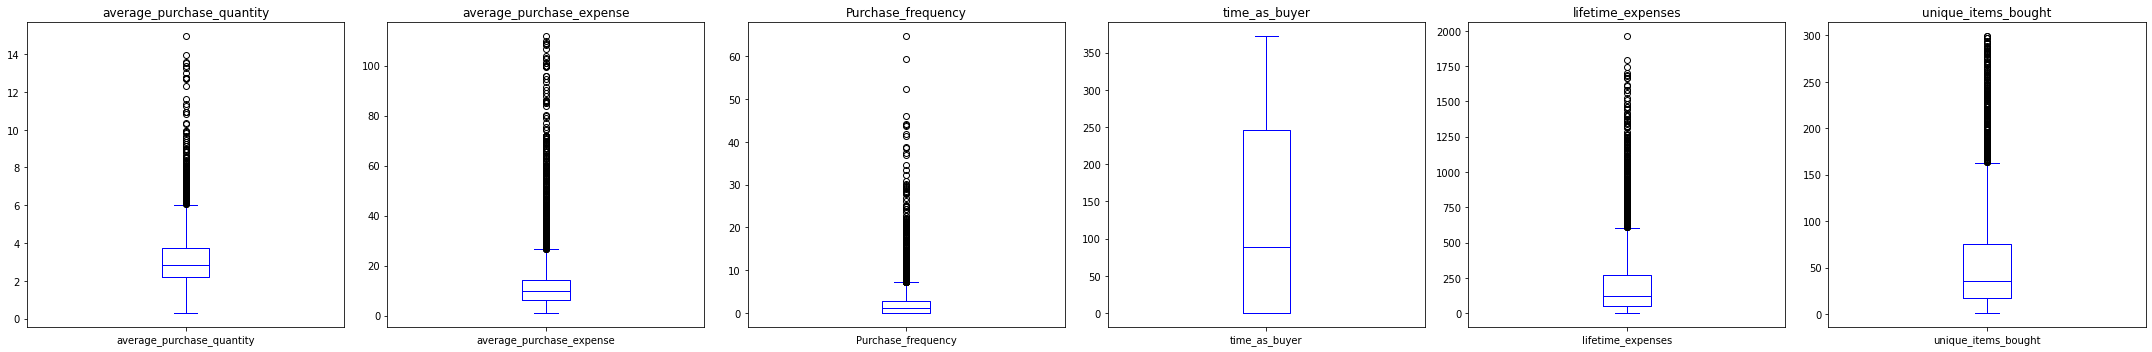

In [56]:
plot_boxplots(df)

In [ ]:
correlation_matrix = df[
    ["average_purchase_quantity",
     "average_purchase_expense",
     "Purchase_frequency",
     "lifetime_expenses"]
     ].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            linewidths=0.5)
plt.show()


"The time as a buyer is proportionally related to the unique number of items that customer has bought and the more unique items they've bought the higher their life time expenses turn out to be"

In [40]:
import itertools

def plot_scatter_plots(df):
    numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

    feature_combinations = list(itertools.combinations(numerical_features, 2))

    num_combinations = len(feature_combinations)
    fig, axes = plt.subplots(1, num_combinations, figsize=(5 * num_combinations, 5))

    for i, (x_feature, y_feature) in enumerate(feature_combinations):
        df.plot.scatter(x=x_feature, y=y_feature, ax=axes[i], color='skyblue')
        axes[i].set_title(f"{x_feature} vs {y_feature}")
    
    plt.tight_layout()
    plt.show()

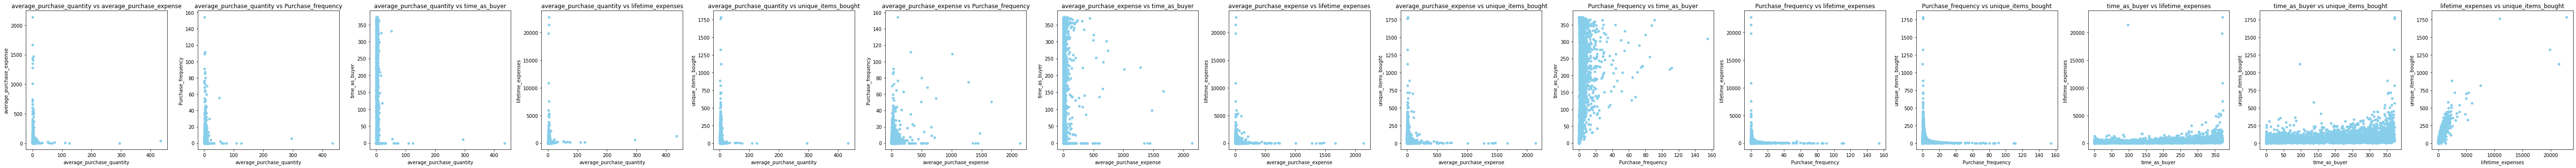

In [41]:
plot_scatter_plots(df)

In [42]:
df = df[df["average_purchase_quantity"]<15]
df = df[df["average_purchase_expense"]<120]
df = df[df["Purchase_frequency"]<70]
df = df[df["time_as_buyer"]<1250]
df = df[df["lifetime_expenses"]<2000]
df = df[df["unique_items_bought"]<300]

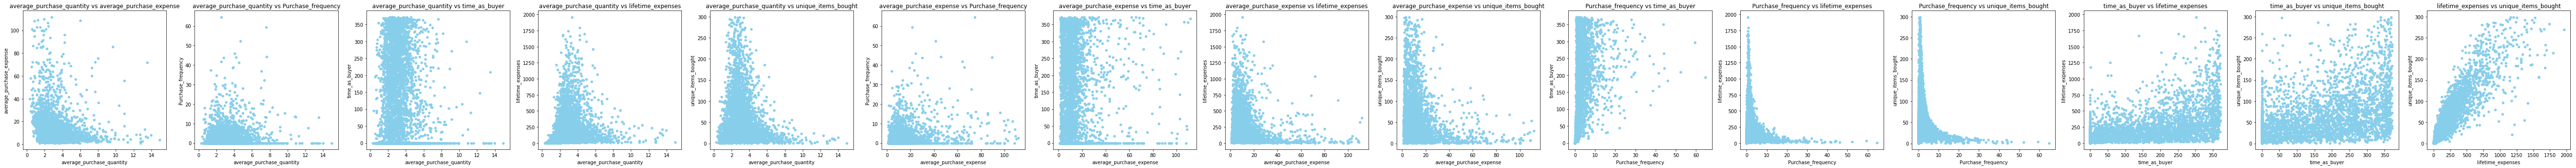

In [43]:
plot_scatter_plots(df)

### PCA

In [44]:
from sklearn.preprocessing import StandardScaler

features = df.select_dtypes(include=[np.number])
features = df[["average_purchase_quantity", "average_purchase_expense","Purchase_frequency","lifetime_expenses"]]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [45]:
features["average_purchase_quantity_log"] = np.log1p(features["average_purchase_quantity"])
features["average_purchase_expense_log"] = np.log1p(features["average_purchase_expense"])
features["lifetime_expenses_log"] = np.log1p(features["lifetime_expenses"])

C:\Users\nehue\AppData\Local\Temp\ipykernel_6764\1191329463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["average_purchase_quantity_log"] = np.log1p(features["average_purchase_quantity"])
C:\Users\nehue\AppData\Local\Temp\ipykernel_6764\1191329463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["average_purchase_expense_log"] = np.log1p(features["average_purchase_expense"])
C:\Users\nehue\AppData\Local\Temp\ipykernel_6764\1191329463.py:3: SettingWithCopyWarning: 
A value is tryi

In [46]:
features_2 = features[["average_purchase_quantity_log", "average_purchase_expense_log", "lifetime_expenses_log", "Purchase_frequency"]]
scaled_features = scaler.fit_transform(features_2)

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

In [48]:
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

TypeError: 'AxesSubplot' object is not subscriptable

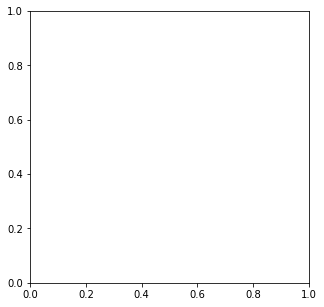

In [49]:
plot_scatter_plots(pca_df)

In [ ]:
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by each component: {explained_variance}")

Explained Variance by each component: [0.39773503 0.27287366]


The PC variance is too low, would rather use another method...

average_purchase_quantity        2.147816
average_purchase_expense         3.542356
Purchase_frequency               4.837542
time_as_buyer                    0.479960
lifetime_expenses                2.393730
unique_items_bought              1.757961
Country_Australia               22.685348
Country_Austria                 19.324989
Country_Bahrain                 45.469762
Country_Belgium                 12.753195
Country_Brazil                  64.327288
Country_Canada                  37.112431
Country_Channel Islands         22.685348
Country_Cyprus                  24.260487
Country_Czech Republic          64.327288
Country_Denmark                 21.380162
Country_EIRE                    64.327288
Country_European Community      64.327288
Country_Finland                 18.495519
Country_France                   6.720882
Country_Germany                  6.408923
Country_Greece                  32.128636
Country_Iceland                 64.327288
Country_Israel                  37